In [1]:
# changer le répertoire de travail du notebook vers le répertoire parent.
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

/data/dhryniewski/DataScientest/doc-classifier


----

# Tesseract

Pour installer `tesseract` vous trouverez toutes les informations sur: [tesseract-ocr.github.io](https://tesseract-ocr.github.io/tessdoc/Installation.html)

Pour le projet nous utilisons tesseract `4.1.1`

In [2]:
import pytesseract

# A remplacer par le chemin ou est situé votre tesseract
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

Nous allons utiliser tesseract sur les bases de données :

- Projet OCR classification (data_02)
- RVL-CDIP Dataset (5% of original dataset) (data_03)
- PRADO (data_04)

La base de données "Text extraction for OCR" (data_01) à déjà une annotation textuelle.

----

# Téléchargement de resultats:

```⚠️ Attention ⚠️``` Le traitement de chaque dataset peut prendre __plusieurs heures__. Vous pouvez directement télécharger les resultats:

Name | Size | Download
-----|------|-----------
Projet OCR classification | 2.5 Mo | [Google Drive](https://drive.google.com/file/d/1gp5QH5X8XKDXPkP1zBpw8fVji-m0VCfF/view?usp=sharing)
RVL-CDIP Dataset (5% of original dataset)| 44.3 Mo | [Google Drive](https://drive.google.com/file/d/1ovi31tTZKfRxH3NHNXUzB5j-93WIwzA2/view?usp=sharing)
PRADO | 505 Ko | [Google Drive](https://drive.google.com/file/d/1E_2ZbPxLj5w-ceRuN8jRl2p4n8Q76sBp/view?usp=sharing)


Chaque fichier contient:
- __tesseract_ocr__         -> dossier avec les resultats de tesseract (sous format csv) pour chaque image.
- __tesseract_ost.csv__         -> les resultats de chaque osd (orientation and script detection) pour chaque image.
- __text_process.csv__          -> les résultat de texte processing pour chaque image.

In [ ]:
from src import extract_tar_gz

# Extraire tout les resultats:
extract_tar_gz("path/to/tesseract_data_02.tar.gz", 'data/raw/data_02')
extract_tar_gz("path/to/tesseract_data_03.tar.gz", 'data/raw/data_03')
extract_tar_gz("path/to/tesseract_data_04.tar.gz", 'data/raw/data_04')

----

# I - Exemple d'utilisation de Tesseract

In [3]:
import cv2
import random

from src import draw_tesseract_result, plot_image, image_rotate
random.seed(111)

### OCR (optical character recognition)

Pour plus d'information sur les options de tesseract: [Tesseract Options](https://muthu.co/all-tesseract-ocr-options/)

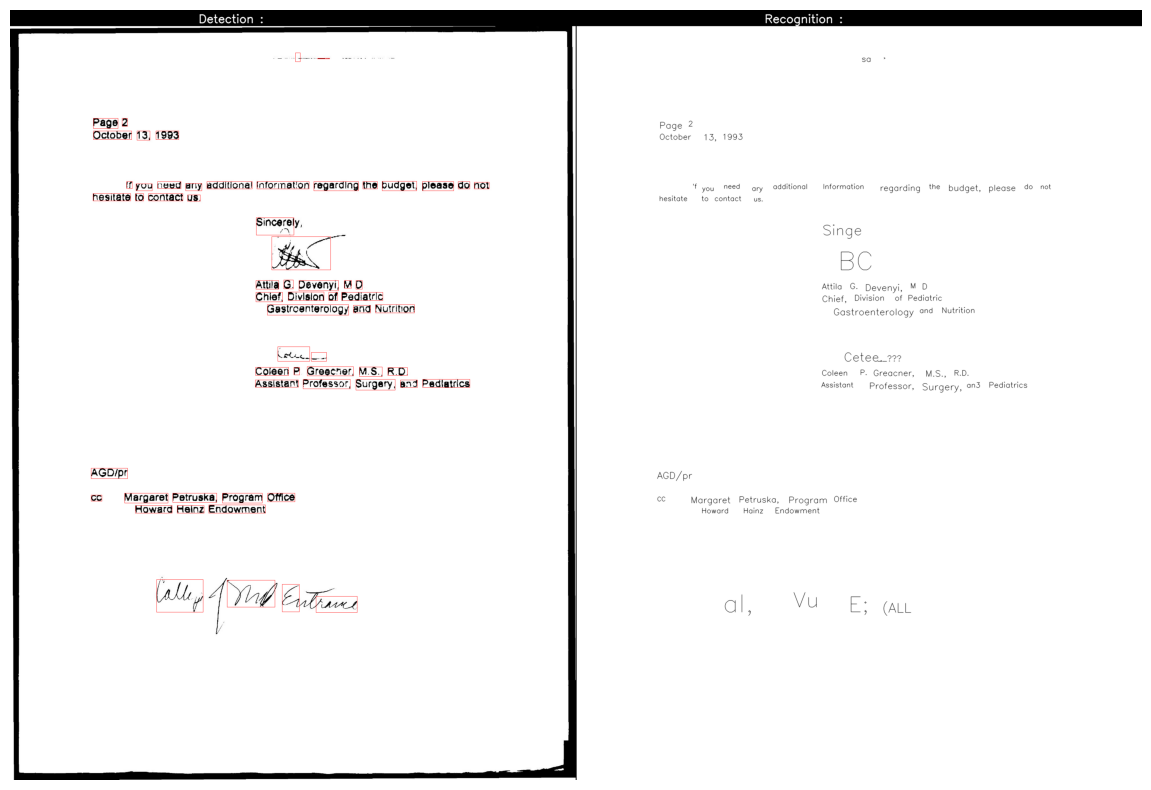

In [4]:
# Selection d'une image aléatoire de la base de données Projet OCR classification
data_dir = "data/raw/data_02" 
images_dir = os.path.join(data_dir, "images")
image_name = random.choice(os.listdir(images_dir))
image_path = os.path.join(images_dir, image_name)


image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

result = pytesseract.image_to_data(image,
                                   lang='eng+fra',
                                   config='--psm 11',
                                   output_type='data.frame')
result.dropna(subset='text', inplace=True, ignore_index=True)

image_result = draw_tesseract_result(result, image)
plot_image(image_result, size=(15, 10), flip_image_layers=False)

## OSD (orient and script detection)

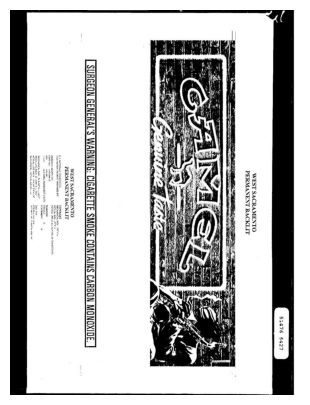

In [4]:
image_path = "data/raw/data_02/images/img_0001354.jpg"
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
plot_image(image, size=(5, 5), flip_image_layers=False)

In [5]:
from pytesseract import Output
result = pytesseract.image_to_osd(image, output_type=Output.DICT)
print(result)

{'page_num': 0, 'orientation': 90, 'rotate': 270, 'orientation_conf': 1.64, 'script': 'Cyrillic', 'script_conf': 5.33}


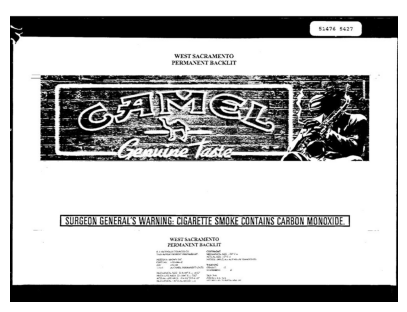

In [6]:
image_rot = image_rotate(image, result['rotate'], auto_bound=True)
plot_image(image_rot, size=(5, 5), flip_image_layers=False)

# II - Exemple de prétraitement de Texte

In [4]:
import pandas as pd

# Lecture d'un résultat d'ocr de tesseract
tesseract_ocr_file = "data/raw/data_02/tesseract_ocr/img_0000000.csv"
df_ocr = pd.read_csv(tesseract_ocr_file)
df_ocr.head()

/tmp/ipykernel_1760033/2518600014.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,56,48,195,54,91,FACTURE
1,5,1,2,1,1,1,619,81,69,23,96,LOGO
2,5,1,3,1,1,1,55,130,43,10,93,Joanna
3,5,1,3,1,1,2,103,130,31,10,95,Binet
4,5,1,4,1,1,1,54,152,15,10,68,48


In [8]:
from nltk.tokenize.regexp import RegexpTokenizer

# On utilise une expression régulière pour diviser un texte en mots, en ignorant les mots trop courts.
tokenizer = RegexpTokenizer("[a-zA-Zéèàçê]{3,}")

words = ' '.join(df_ocr['text'].to_list())
tokens = tokenizer.tokenize(words.lower())
tokens

['facture',
 'logo',
 'joanna',
 'binet',
 'coubertin',
 'paris',
 'facture',
 'envoye',
 'facture',
 'cendritlon',
 'ayot',
 'cendrilon',
 'ayot',
 'date',
 'rue',
 'nations',
 'rue',
 'ferréol',
 'paris',
 'france',
 'commande',
 'échéance',
 'qté',
 'désignation',
 'prix',
 'unit',
 'montant',
 'grand',
 'brun',
 'escargot',
 'pour',
 'manger',
 'petit',
 'marinière',
 'uniforme',
 'bleu',
 'facile',
 'jouer',
 'total',
 'total',
 'conditions',
 'modalités',
 'paiement',
 'paiement',
 'est',
 'dans',
 'jours',
 'caisse',
 'epargne',
 'iban',
 'swift',
 'bic',
 'abcdfrp',
 'xxx']

In [9]:
from src import detect_lang

# nous allos detecter la langue en utilisant la librairie spacy_langdetect
lang = detect_lang(tokens)
lang

{'language': 'fr', 'score': 0.9999966317943368}

In [11]:
from src import stop_words_filtering
from src import lemmatize_english, lemmatize_french

# On adapte le prétraitement des tokens en fonction de la langue détectée dans le texte,
# en appliquant des filtres de mots vides et en effectuant la lemmatisation correspondante
# pour chaque langue (français ou anglais).
if lang['language'] == 'fr' and lang['score'] > 0.5:
    words_filter = stop_words_filtering(tokens, 'french')
    lemmatized_tokens = lemmatize_french(words_filter)
else:
    words_filter = stop_words_filtering(tokens, 'english')
    lemmatized_tokens = lemmatize_english(words_filter)

lemmatized_tokens

['factur',
 'logo',
 'joanna',
 'binet',
 'coubertin',
 'pari',
 'factur',
 'envoye',
 'factur',
 'cendritlon',
 'ayot',
 'cendrilon',
 'ayot',
 'date',
 'rue',
 'nation',
 'rue',
 'ferréol',
 'pari',
 'france',
 'command',
 'échéance',
 'qté',
 'désignation',
 'prix',
 'unir',
 'montant',
 'grand',
 'brun',
 'escargot',
 'manger',
 'petit',
 'marinier',
 'uniforme',
 'bleu',
 'facile',
 'jouer',
 'total',
 'total',
 'condition',
 'modalité',
 'paiement',
 'paiement',
 'jour',
 'caisse',
 'epargn',
 'iban',
 'swift',
 'bic',
 'abcdfrp',
 'xxx']

### Tesseract et le text processing sur les datasets.

⚠️ Attention le traitement est très long !

In [ ]:
from typing import List, Optional, Union
from tqdm import tqdm

from src import tesseract_data_process

In [ ]:
tesseract_data_process("data/raw/data_02") # environ 1 heure
tesseract_data_process("data/raw/data_03") # environ 12 heures
tesseract_data_process("data/raw/data_04") # environ 30 min

In [13]:
def text_process(
    words: Union[List[str], str],
    tokenizer: Optional[RegexpTokenizer] = None,
    lang_threshold: float = 0.5
    ) -> dict:

    if isinstance(words, list):
        words = ' '.join(words)

    if tokenizer is None:
        tokenizer = RegexpTokenizer("[a-zA-Z]{3,}")

    tokens = tokenizer.tokenize(words.lower())
    lang = detect_lang(tokens)

    if lang['language'] == 'fr' and lang['score'] > lang_threshold:
        words_filter = stop_words_filtering(tokens, 'french')
        lemmatized_tokens = lemmatize_french(words_filter)
    else:
        words_filter = stop_words_filtering(tokens, 'english')
        lemmatized_tokens = lemmatize_english(words_filter)

    data = {
        "words": lemmatized_tokens,
        "lang": lang['language'],
        "lang_score": lang['score'],
    }

    return data

In [ ]:
# environ 5 heures
pths = ["data/raw/data_02", "data/raw/data_03", "data/raw/data_04"]
for dataset_path in pths:
    out_data = []
    if dataset_path == "data/raw/data_02":
        df = pd.read_csv(os.path.join(dataset_path, "other_data.csv"))
        df.rename(columns={"filename": "image_name", "type": "category"}, inplace=True)
    else:
        df = pd.read_csv(os.path.join(dataset_path, "categories.csv"))

    df['name'] = df['image_name'].apply(lambda x: os.path.splitext(x)[0])
    for row in tqdm(df.iloc, total=len(df)):
        category = row['category']
        file_name = row['name']

        df_ocr = pd.read_csv(os.path.join(dataset_path, "tesseract_ocr", f"{file_name}.csv"))
        df_ocr['text'] = df_ocr['text'].astype(str)
        words = df_ocr['text'].to_list()
        process_result = text_process(words, tokenizer)
        process_result['file_name'] = file_name
        process_result['file_name'] = file_name
        process_result['category'] = category
        process_result['words'] = ' '.join(process_result['words'])
        out_data.append(process_result)

    pd.DataFrame(out_data).to_csv(os.path.join(dataset_path, "text_process.csv"), index=False)